In [1]:
import os
import analysis
from analysis import mean_phase, ipr, pca_entropy, renyi_entropy, infidelity
import matplotlib.pyplot as plt

In [2]:
hypotheses = {
    "mean_phase" : mean_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
}


h5_files = [os.path.join("data_rand", f) for f in os.listdir('data_rand') if f.endswith('.h5')]

df = analysis.load_outputs_to_dataframe(h5_files)
df = analysis.attach_hypotheses_fields(df, hypotheses)
epsilons = [analysis.read_h5_attributes(f)["epsilon"] for f in h5_files]
df["epsilon"] = epsilons
print(len(df))

267


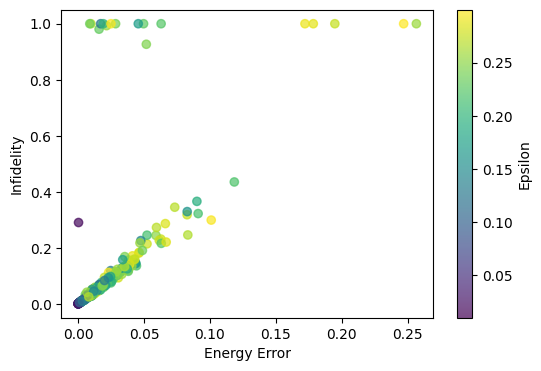

In [5]:
plt.figure(figsize=(6, 4))
scatter = plt.scatter(df["Delta_E"], df["infidelity"], c=df["epsilon"], cmap='viridis', alpha=0.7)
plt.xlabel("Energy Error")
plt.ylabel("Infidelity")
cbar = plt.colorbar(scatter)
cbar.set_label("Epsilon")
plt.show()

/tmp/ipykernel_3264751/2984725371.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


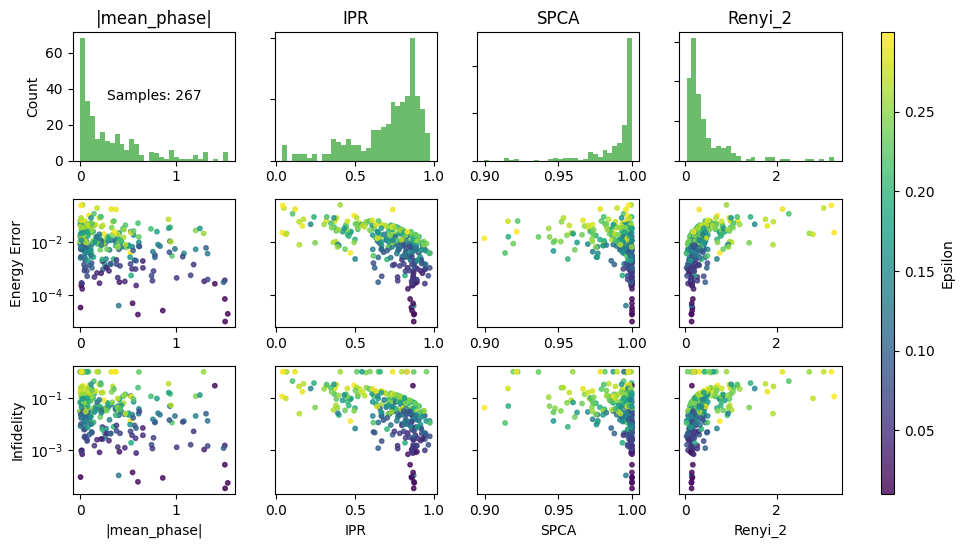

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

scatter_size = 10
N = len(hypotheses)
fig = plt.figure(figsize=(0.6*4*N + 1, 0.6*10))  # Extra width for colorbar
gs = gridspec.GridSpec(3, N+1, width_ratios=[1]*N + [0.08], wspace=0.3, hspace=0.3)

axes = np.empty((3, N), dtype=object)
for row in range(3):
    for col in range(N):
        axes[row, col] = fig.add_subplot(gs[row, col])

for idx, name in enumerate(hypotheses.keys()):
    # First row: Histogram
    if name == "mean_phase":
        data = df[name].abs()  # Use absolute value for mean_phase
        title = f"|{name}|"
    else:
        data = df[name]
        title = name
    

    axes[1, idx].set_yscale("log")
    axes[2, idx].set_yscale("log")

    axes[0, idx].hist(data, bins=30, color="C2", alpha=0.7)
    axes[0, idx].set_title(title)
    if idx == 0:
        axes[0, 0].set_ylabel("Count")
    else:
        axes[0, idx].tick_params(axis='y', labelleft=False)

    # Second row: Energy error vs hypothesis
    scatter = axes[1, idx].scatter(data, df["Delta_E"], c=df["epsilon"], cmap='viridis', alpha=0.8, s=scatter_size)
    if idx == 0:
        axes[1, 0].set_ylabel("Energy Error")
    else:
        axes[1, idx].tick_params(axis='y', labelleft=False)
    aligned_infid = df["infidelity"]
    axes[2, idx].scatter(data, aligned_infid, c=df["epsilon"], cmap='viridis', alpha=0.8, s=scatter_size)
    axes[2, idx].set_xlabel(title)
    if idx == 0:
        axes[2, 0].set_ylabel("Infidelity")
    else:
        axes[2, idx].tick_params(axis='y', labelleft=False)
# Colorbar in the rightmost column, spanning all rows
plt.tight_layout()
cbar_ax = fig.add_subplot(gs[:, -1])
axes[0, 0].text(0.5, 0.5, f"Samples: {len(df)}", transform=axes[0, 0].transAxes, 
                fontsize=10, color="black", ha="center", va="center")
cbar = fig.colorbar(scatter, cax=cbar_ax)
cbar.set_label("Epsilon")

plt.show()

In [ ]:
A = np.random.rand(100000).astype(np.float64)
def t1(A):
    return np.sum(A)

def t2(A):
    res = np.float64(0.)
    for a in A:
        res += a
    return res

def t3(A):
    res = 0.
    for a in A:
        res += a
    return res

In [ ]:
%timeit t1(A)

12 μs ± 46.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%timeit t2(A)

3.55 ms ± 359 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
